In [ ]:
!pip install pillow

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline


from glob import glob
import os 

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score

from imblearn.over_sampling import SMOTE

import torch
from torch import nn, optim
import timm

import random

from PIL import Image

import albumentations as A
from albumentations.pytorch import ToTensorV2

from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm 

device = 'cuda' if torch.cuda.is_available() else 'cpu'

오토인코더 : 입력 x / 출력도 x  
신경망은 범용 근사자 (universal function approximator) 이므로, 완전히 x와 같진 않다  
정보 손실값 : reconstruction loss라는 용어 사용 
  
신경망의 차원이 줄어든다  
작은 차원으로 압축 -> latent variable(잠재변수)  
잠재변수의 앞(encoder), 뒤(decoder)  
  
주로 복잡한 비선형 데이터의 차원을 줄이는 용도로 사용됨 

In [26]:
df_train = pd.read_csv('mnist/train.csv')
df_test = pd.read_csv('mnist/test.csv')
submission = pd.read_csv('mnist/sample_submission.csv')

In [3]:
def seed_everything(seed) :
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    

def NMAE(true, pred) : 
    mae = np.mean(np.abs(true-pred))
    score = mae/np.mean(np.abs(true))
    return score

SEED = 42
seed_everything(SEED)

In [4]:
IMAGE_SIZE = 28
TEST_SIZE = 0.2
N_EPOCH = 10
LR = 1e-3
BATCH_SIZE = 64
#MODEL_NAME = 'densenet121'

# Dataset

In [27]:
class train_dataset(Dataset) :
    def __init__(self, train_df, transform=None ) :
        super(train_dataset).__init__()
        self.train_df = train_df.drop(['index', 'label'],1)
        self.target = train_df.label
        self.transform = transform 
        
    def __len__(self) : 
        return len(self.train_df)
    
    def __getitem__(self, idx) : 
        img = self.train_df.to_numpy()[idx].reshape(28,28)
        #img = torch.tensor(img/255).view(1,28,28)
        img = torch.tensor(img/255)
        img = img.type(torch.float32)
        
        #if self.transform : 
        #    img = self.transform(image=img)['image']
        
        target = self.target[idx]
        target = torch.tensor(target, dtype=torch.float32)
        
        return img, target

In [6]:
class test_dataset(Dataset) : 
    def __init__(self, test_imgs, transform =None) :
        super(test_dataset).__init__() 
        self.test_imgs = test_imgs.drop(['index'], 1)
        self.transform = transform
        
    def __len__(self) :
        return len(self.test_imgs)
    
    def __getitem__(self, idx) :  
        img = self.test_imgs.to_numpy()[idx].reshape(28,28)
        img = torch.tensor(img/255).view(1,28,28)
        img = img.type(torch.float32)        
        #if self.transform : 
        #    img = self.transform(image=img)['image']
            
        return img
        

In [7]:
img_transform = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE), 
    A.Normalize(),
    ToTensorV2()
])

# DataLoader 

In [28]:
train_loader = DataLoader(train_dataset(df_train), batch_size = BATCH_SIZE, shuffle=True)

In [9]:
test_loader = DataLoader(test_dataset(test), batch_size = BATCH_SIZE, shuffle=False)

# Encoder Model

In [29]:
class Autoencoder(nn.Module) : 
    def __init__(self) : 
        super(Autoencoder, self).__init__()
        
        self.encoder = torch.nn.Sequential(
            nn.Linear(28*28, 128), 
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(), 
            nn.Linear(64, 12), 
            nn.ReLU(),
            nn.Linear(12,3)
        )
        
        self.decoder = torch.nn.Sequential(
            nn.Linear(3, 12), 
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )
        
        
    def forward(self, x) : 
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        return encoded, decoded

In [11]:
autoencoder = Autoencoder().to(device)

In [12]:
criterion = torch.nn.MSELoss().to(device)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)

In [ ]:
from torchvision import transforms, datasets

trainset = datasets.FashionMNIST(
    root      = './.data/', 
    train     = True,
    download  = True,
    transform = transforms.ToTensor()
)
train_loader = torch.utils.data.DataLoader(
    dataset     = trainset,
    batch_size  = BATCH_SIZE,
    shuffle     = True,
    num_workers = 2
)

# Train/Validation

In [44]:
view_data = df_train.iloc[:5,:].drop(['label', 'index'], 1).to_numpy()

In [54]:
view_data = torch.tensor(view_data)

In [59]:
view_data = view_data.type(torch.float32)

In [60]:
def train(autoencoder, train_loader) : 
    autoencoder.train()
    for step, (x, label) in enumerate(train_loader) :
        x = x.view(-1,28*28).to(device)
        y = x.view(-1,28*28).to(device)
        label = label.to(device)
        
        encoded, decoded = autoencoder(x)
        
        loss = criterion(decoded, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

[Epoch 0]


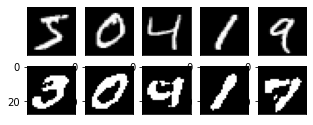

[Epoch 1]


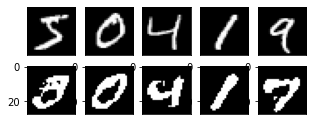

[Epoch 2]


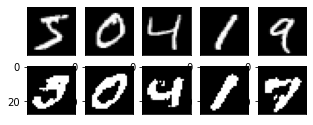

[Epoch 3]


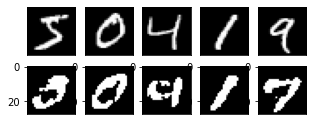

[Epoch 4]


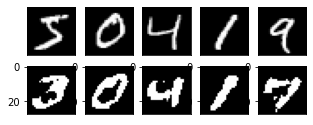

[Epoch 5]


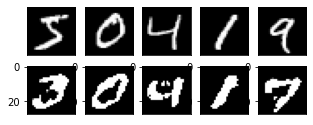

[Epoch 6]


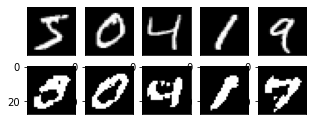

[Epoch 7]


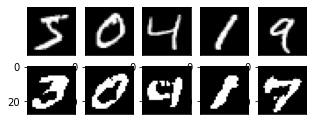

[Epoch 8]


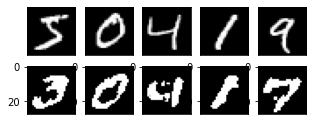

[Epoch 9]


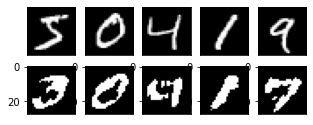

In [72]:
for epoch in range(N_EPOCH) : 
    train(autoencoder, train_loader)
    
    test_x = view_data.to(device)
    _, decoded_data = autoencoder(test_x)
    
    f, a =plt.subplots(2,5, figsize=(5,2))
    print(f'[Epoch {epoch}]')
    
    for i in range(5) : 
        img = np.reshape(view_data.numpy()[i], (28,28))
        a[0][i].imshow(img, cmap='gray')
        a[0][i].set_xticks(()); a[0][i].set_yticks(())
        
    for i in range(5) : 
        img = np.reshape(decoded_data.detach().cpu().numpy()[i], (28,28))
        a[1][i].imshow(img, cmap='gray')
        a[1][i].set_xticks(()); a[0][i].set_yticks(())
    
    plt.show()

# Noise add

In [73]:
def add_noise(img) : 
    noise = torch.randn(img.size())*0.1
    
    noisy_img = img + noise 
    return noisy_img

# train 코드에 add noise code추가

In [74]:
def train(autoencoder, train_loader) : 
    autoencoder.train()
    avg_loss = 0
    for step, (x, label) in enumerate(train_loader) :
        noisy_x = add_noise(x)
        noisy_x = noisy_x.view(-1,28*28).to(device)
        y = x.view(-1,28*28).to(device)
        label = label.to(device)
        
        encoded, decoded = autoencoder(noisy_x)
        
        loss = criterion(decoded, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        avg_loss += loss.item()
    
    return avg_loss/len(train_loader)

In [76]:
for epoch in range(N_EPOCH) : 
    loss = train(autoencoder, train_loader)
    print(f'[Epoch {epoch+1}   loss :{loss}]')

[Epoch 1   loss :0.03218028755949886]
[Epoch 2   loss :0.031948101371208994]
[Epoch 3   loss :0.03181672410598632]
[Epoch 4   loss :0.03170791351154987]
[Epoch 5   loss :0.03160693372554108]
[Epoch 6   loss :0.03156062507076558]
[Epoch 7   loss :0.03144766611537572]
[Epoch 8   loss :0.031347164483085624]
[Epoch 9   loss :0.03132575309908848]
[Epoch 10   loss :0.03127798505190974]


In [101]:
sample_data = df_test.iloc[55].drop('index')

In [102]:
sample_data = torch.tensor(sample_data.to_numpy()/255).type(torch.float32)

In [105]:
original_x = sample_data
noisy_x = add_noise(original_x).to(device)
_, recovered_x = autoencoder(noisy_x)

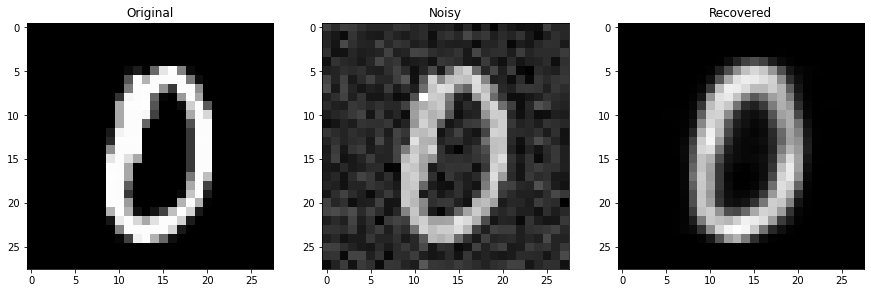

In [107]:
f, a = plt.subplots(1,3, figsize=(15,15))

original_img = np.reshape(original_x.to("cpu").data.numpy(), (28, 28))
noisy_img = np.reshape(noisy_x.to("cpu").data.numpy(), (28, 28))
recovered_img = np.reshape(recovered_x.to("cpu").data.numpy(), (28, 28))

# 원본 사진
a[0].set_title('Original')
a[0].imshow(original_img, cmap='gray')

# 오염된 원본 사진
a[1].set_title('Noisy')
a[1].imshow(noisy_img, cmap='gray')

# 복원된 사진
a[2].set_title('Recovered')
a[2].imshow(recovered_img, cmap='gray')

plt.show()